# Goal

Implement electricity demand forecasting with Gradient Boosting (XGBoost) ensemble tree method.

- Perform timeseries cross validation
- Leave 7-day window at end so there's always a test set

# Import Packages

Third-Pary packages:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import sys
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

My core package:

In [5]:
sys.path.append('../')
from core.data import add_temporal_features

# Data

In [6]:
# Import Data
df = pd.read_csv('eia_api_pjm_demand.csv')

# Cast column types
df['utc_ts'] = pd.to_datetime(df['utc_ts'], utc=True)
df = df.set_index('utc_ts')
df['D'] = pd.to_numeric(df['D'])
df['DF'] = pd.to_numeric(df['DF'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78840 entries, 2015-07-01 05:00:00+00:00 to 2024-06-28 04:00:00+00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   respondent  78834 non-null  object 
 1   D           78667 non-null  float64
 2   DF          78551 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.4+ MB


# Timeseries Cross Validation

For timeseries, our K-fold cross validation splits must still preserve the sequential nature of our dataset (test set must always be later in time than training).

## Create and Visualize the train/test splits

In [7]:
# 1 week in hours
TEST_SET_SIZE = 7 * 24
NUM_SPLITS = 5

In [8]:
tss = TimeSeriesSplit(n_splits=NUM_SPLITS, test_size=TEST_SET_SIZE)
print(tss)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=168)


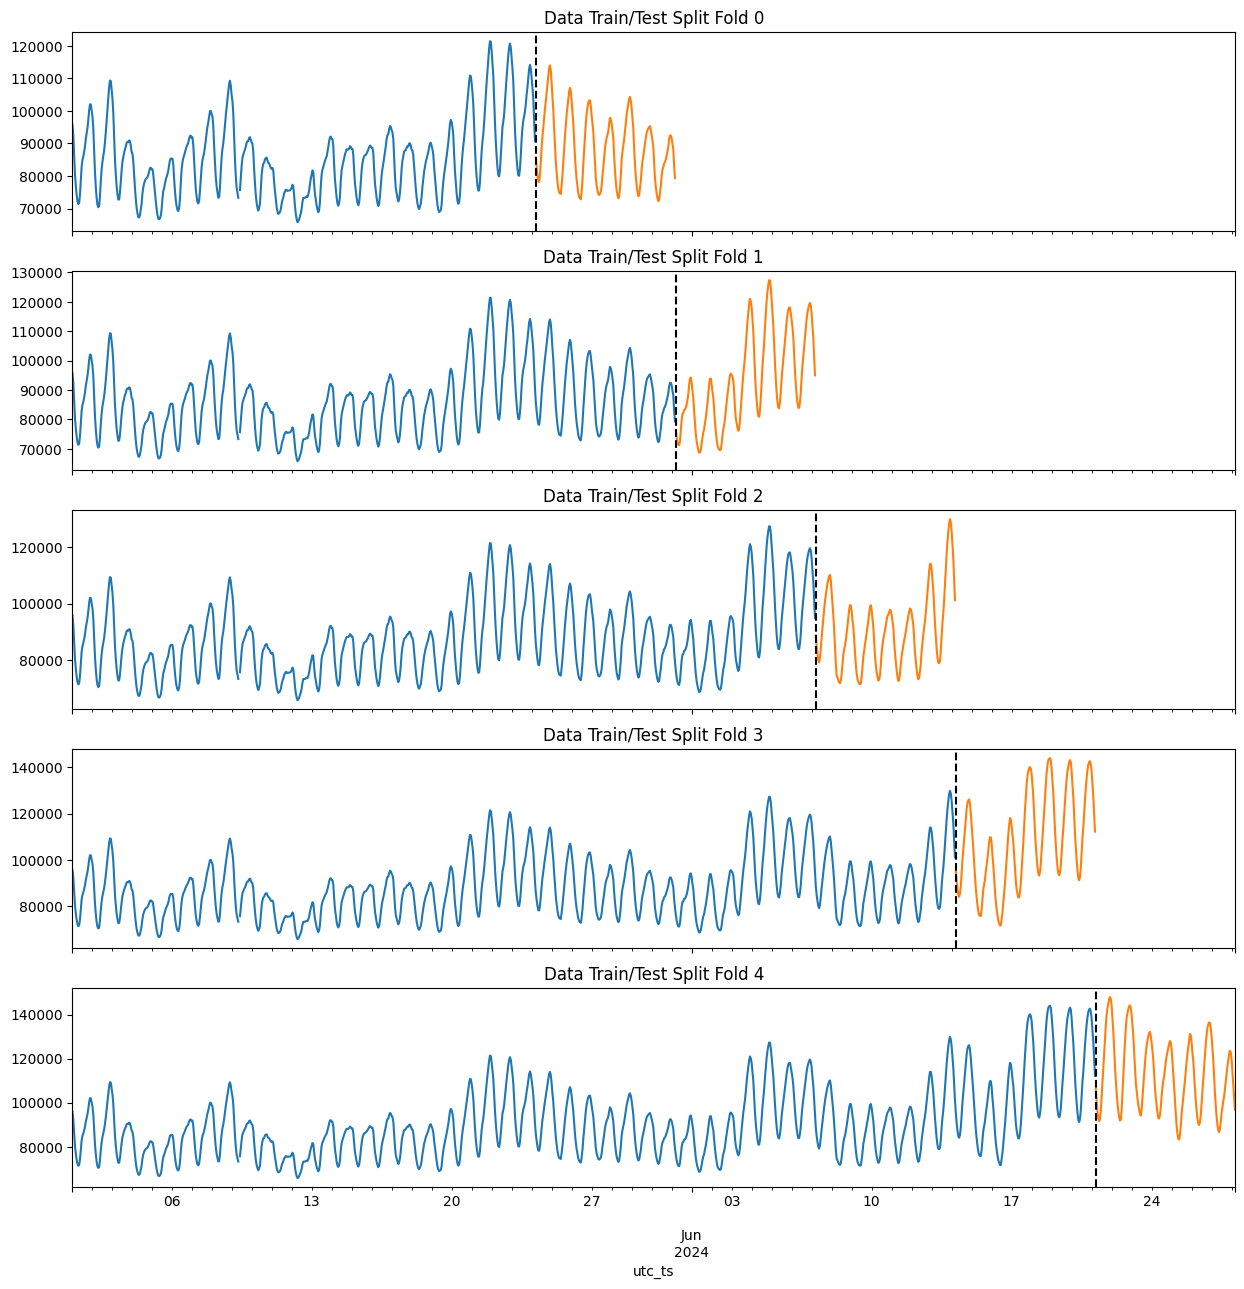

In [9]:
fig, axs = plt.subplots(NUM_SPLITS, 1, figsize=(15, 15), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    # Cut out bulk of common training data for better visualization
    train = train[train.index > '05-01-2024']
    train['D'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['D'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
plt.show()

# Feature Engineering

In [10]:
df = add_temporal_features(df)

In [11]:
df.head()

,respondent,D,DF,month,hour,quarter,dayofyear,dayofmonth
utc_ts,,,,,,,,
2015-07-01 05:00:00+00:00,PJM,84024.0,29415.0,7,5,3,182,1
2015-07-01 06:00:00+00:00,PJM,79791.0,27687.0,7,6,3,182,1
2015-07-01 07:00:00+00:00,PJM,76760.0,26574.0,7,7,3,182,1
2015-07-01 08:00:00+00:00,PJM,74931.0,26029.0,7,8,3,182,1
2015-07-01 09:00:00+00:00,PJM,74368.0,26220.0,7,9,3,182,1


# References
- https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook